# Commulyzer
This notebook is used to train and export the toxicity classifiers on the cleaned Reddit comments.

In [ ]:
import json, csv
from pathlib import Path
from typing import List, Dict

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import Image

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (
    precision_recall_curve, roc_auc_score, average_precision_score,
    f1_score, precision_score, recall_score, accuracy_score,
    multilabel_confusion_matrix, PrecisionRecallDisplay
 )
import joblib

try:
    from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
except Exception as e:
    print("iterative-stratification not found. Install with: pip install iterative-stratification")
    raise

try:
    import torch
    from torch.utils.data import Dataset
    from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                              Trainer, TrainingArguments, set_seed)
    HF_AVAILABLE = True
except Exception:
    HF_AVAILABLE = False

DATA_PROCESSED = Path("data/processed")
MERGED_DIR = DATA_PROCESSED / "merged"
LABELED_DATA_PATH = MERGED_DIR / "merged_comments_labeled_cleaned.csv"
OUTPUTS = Path("outputs"); MODELS = OUTPUTS / "models"; REPORTS = OUTPUTS / "reports"
for p in [DATA_PROCESSED, MERGED_DIR, OUTPUTS, MODELS, REPORTS]:
    p.mkdir(parents=True, exist_ok=True)

if not LABELED_DATA_PATH.exists():
    raise FileNotFoundError(
        f"Cleaned dataset not found: {LABELED_DATA_PATH}. Run merge/label/clean scripts first."
    )

LABELS = ["toxic","severe_toxic","obscene","threat","insult","identity_hate","racism"]
print("Using cleaned dataset:", LABELED_DATA_PATH)
print("Using labels:", LABELS)

Using cleaned dataset: data\processed\merged\merged_comments_labeled_cleaned.csv
Using labels: ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'racism']


In [13]:

def normalize_text(s: str) -> str:
    if not isinstance(s, str): return ""
    s = s.replace("\r", " ").replace("\n", " ").strip()
    return " ".join(s.split())

def safe_read_csv(path: str) -> pd.DataFrame:
    try:
        return pd.read_csv(path, dtype=str, keep_default_na=False, quoting=csv.QUOTE_MINIMAL)
    except Exception as e:
        print(f"Failed to read {path}: {e}")
        return pd.DataFrame()

def save_df(df: pd.DataFrame, path: str):
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(path, index=False, quoting=csv.QUOTE_MINIMAL)
    print(f"Saved: {path} ({len(df)} rows)")


In [14]:
def prepare_frame(df: pd.DataFrame) -> pd.DataFrame:
    need_cols = ["source_subreddit","post_id","comment_id","created_utc","score","body","permalink","post_rank","post_title","subreddit"]
    for c in need_cols:
        if c not in df.columns: df[c] = ""
    for lab in LABELS:
        if lab not in df.columns and f"{lab}_bin" in df.columns: df[lab] = df[f"{lab}_bin"]
        if lab not in df.columns: df[lab] = "0"
        df[lab] = df[lab].astype(str).str.extract(r"(\d)").fillna("0").astype(int).clip(0,1)

    df["body"] = df["body"].astype(str)
    df = df[~df["body"].isin(["", "[deleted]", "[removed]"])].copy()
    df["body_clean"] = df["body"].map(normalize_text)
    df = df[df["body_clean"] != ""]
    df = df[~df["body_clean"].str.startswith("http")].copy()

    if "comment_id" in df.columns:
        df = df.drop_duplicates(subset=["comment_id"])
    else:
        df = df.drop_duplicates(subset=["body_clean"])
    return df

def load_clean_dataset(path: Path) -> pd.DataFrame:
    print(f"Loading cleaned dataset from {path} ...")
    df = safe_read_csv(str(path))
    if df.empty:
        raise ValueError(f"No rows found in {path}. Ensure the file contains labeled comments.")
    prepared = prepare_frame(df)
    print(f"Prepared rows: {len(prepared)}")
    return prepared

merged = load_clean_dataset(LABELED_DATA_PATH)
print("Merged shape:", merged.shape)
merged.head(3)

Loading cleaned dataset from data\processed\merged\merged_comments_labeled_cleaned.csv ...
Prepared rows: 893525
Merged shape: (893525, 38)
Prepared rows: 893525
Merged shape: (893525, 38)
Prepared rows: 893525
Merged shape: (893525, 38)


,source_subreddit,post_id,post_rank,post_title,subreddit,comment_id,parent_id,author,created_utc,created_iso,...,racism_bin,labels,toxic,severe_toxic,obscene,threat,insult,identity_hate,racism,body_clean
0,StellaSora,1olnny0,187,Revenue,StellaSora,nmobnux,t1_nmjancc,98NINJA98,1762073636.0,2025-11-02T08:53:56,...,0,toxic|obscene,1,0,1,0,0,0,0,Lmao 99% of the population don't play stella s...
1,StellaSora,1olnny0,187,Revenue,StellaSora,nml3c3l,t1_nmj7b1l,avelineaurora,1762026690.0,2025-11-01T19:51:30,...,0,toxic|obscene,1,0,1,0,0,0,0,They haven't even done any fixes yet... It's l...
2,StellaSora,1olnny0,187,Revenue,StellaSora,nmk65tt,t1_nmjgnvk,TankedCat,1762016350.0,2025-11-01T16:59:10,...,0,toxic|obscene,1,0,1,0,0,0,0,honestly the ‘war on yuri’ is rooted in the pl...


,Metrik,Nilai
0,Total komentar,"893,525"
1,Jumlah subreddit,17
2,Rata-rata panjang (karakter),113.47
3,Median panjang (karakter),64.0
4,Rata-rata panjang (token),20.61
5,Median panjang (token),12.0


,Label,Jumlah Positif,Persentase (%)
0,toxic,87240,9.76
1,severe_toxic,534,0.06
2,obscene,54036,6.05
3,threat,935,0.10
4,insult,20355,2.28
5,identity_hate,644,0.07
6,racism,1057,0.12


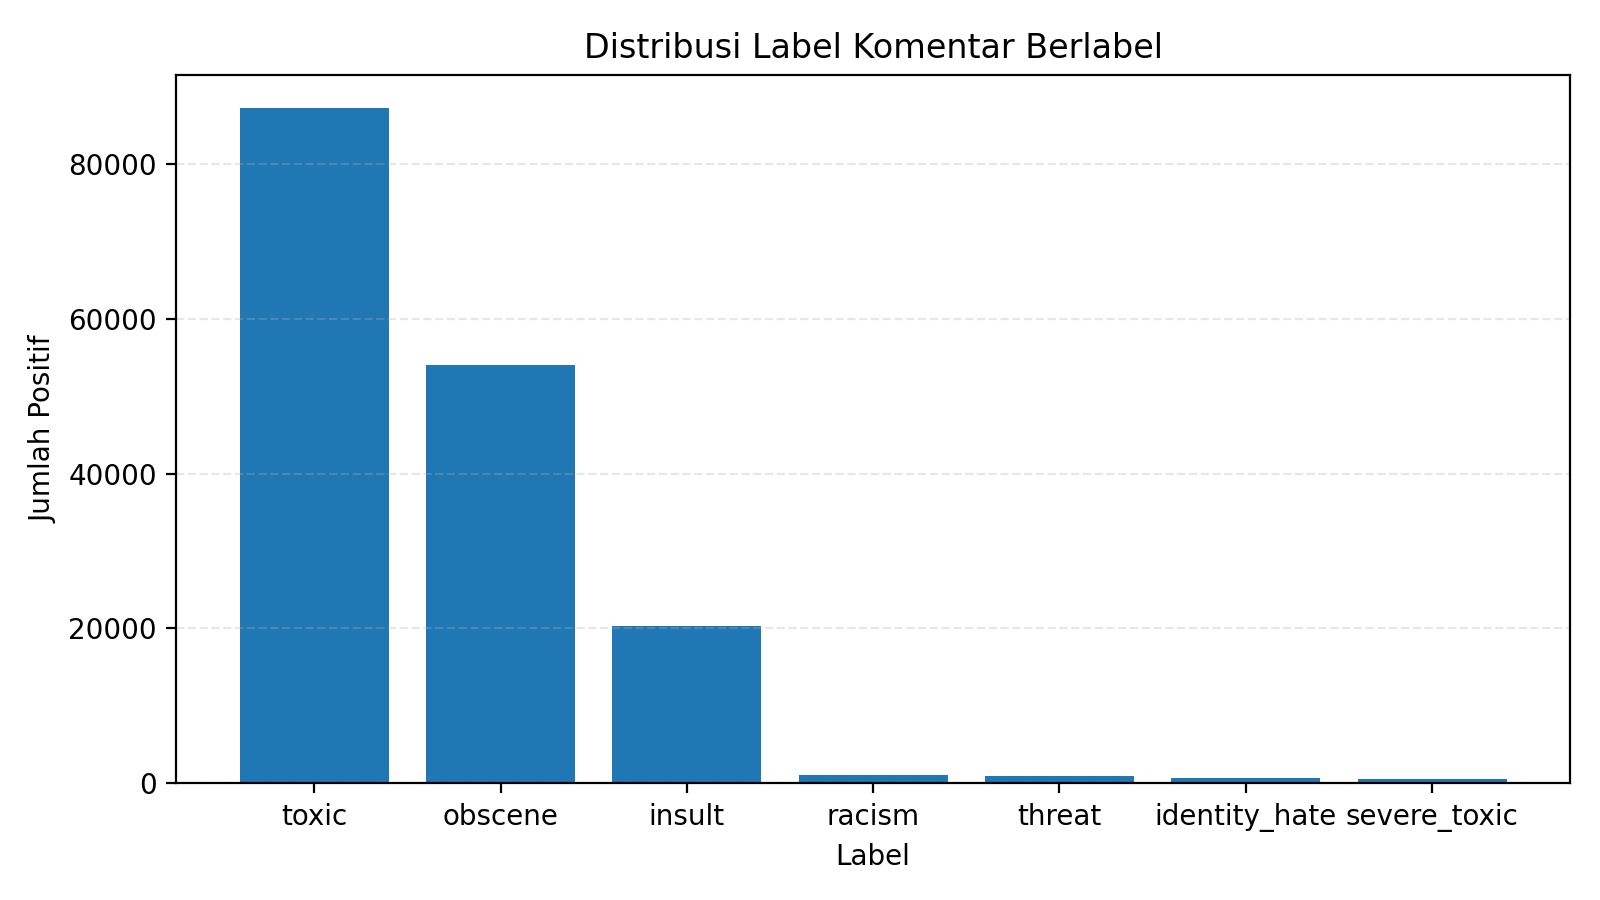

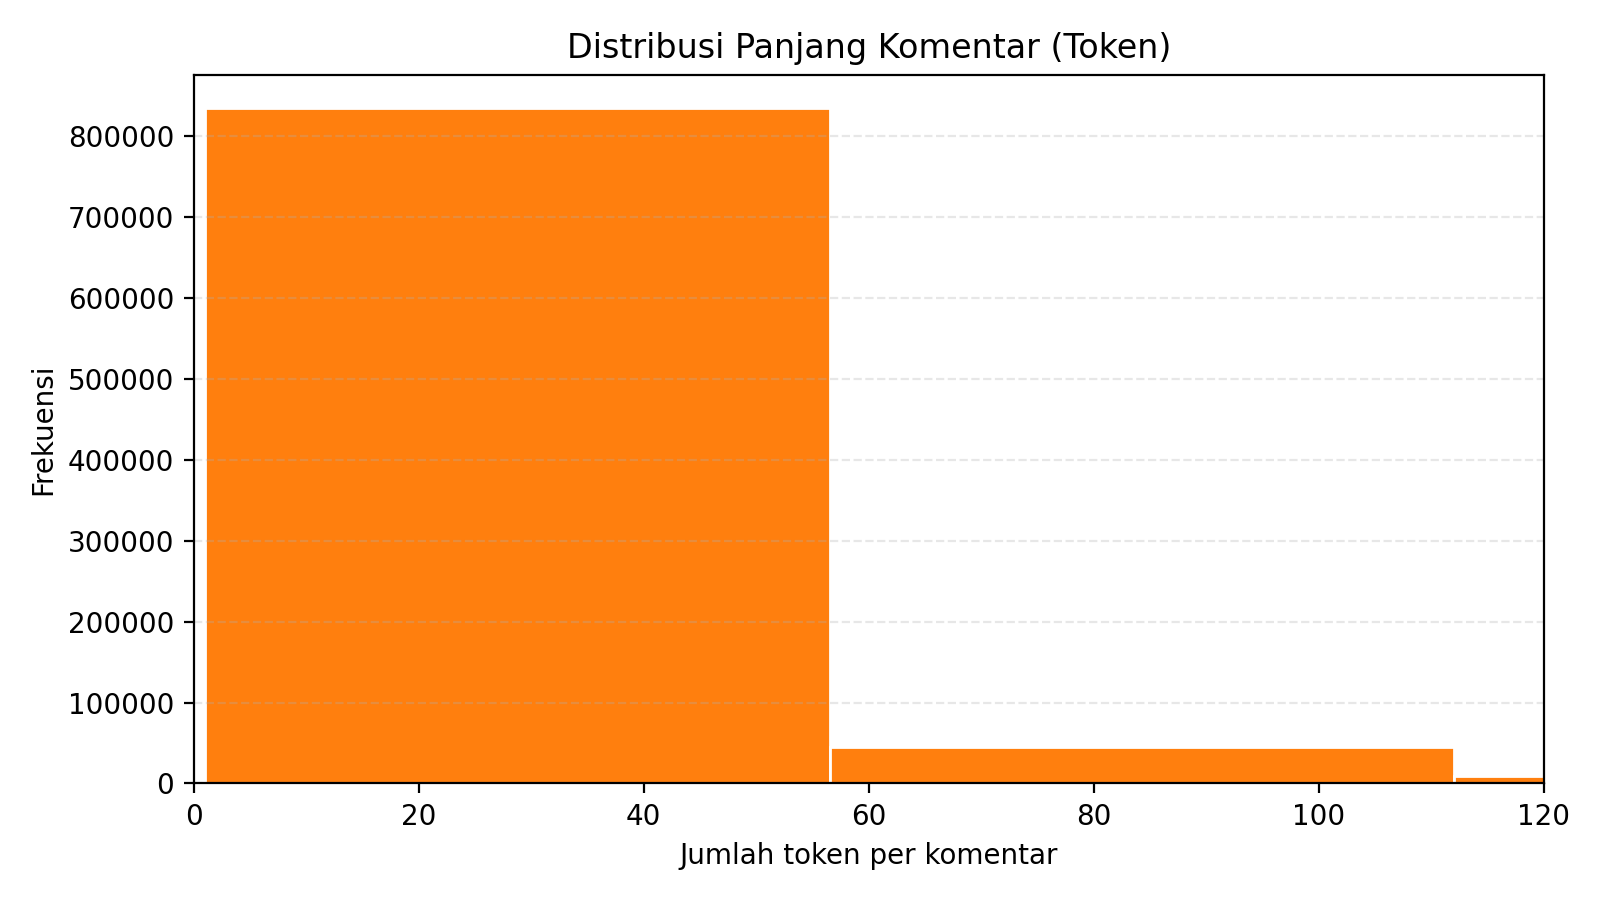

In [15]:
# Dataset summary tables and figures
import matplotlib.pyplot as plt
from IPython.display import display, Image

length_chars = merged["body_clean"].str.len()
length_tokens = merged["body_clean"].str.split().apply(len)

summary_df = pd.DataFrame({
    "Metrik": [
        "Total komentar",
        "Jumlah subreddit",
        "Rata-rata panjang (karakter)",
        "Median panjang (karakter)",
        "Rata-rata panjang (token)",
        "Median panjang (token)",
    ],
    "Nilai": [
        f"{len(merged):,}",
        merged["subreddit"].nunique(),
        round(length_chars.mean(), 2),
        round(length_chars.median(), 2),
        round(length_tokens.mean(), 2),
        round(length_tokens.median(), 2),
    ],
})

label_counts = merged[LABELS].sum().astype(int)
label_ratio = (merged[LABELS].mean() * 100).round(2)
label_table = pd.DataFrame({
    "Label": label_counts.index,
    "Jumlah Positif": label_counts.values,
    "Persentase (%)": label_ratio.values,
})

summary_csv = REPORTS / "dataset_summary_table.csv"
labels_csv = REPORTS / "label_distribution_table.csv"
summary_df.to_csv(summary_csv, index=False)
label_table.to_csv(labels_csv, index=False)

display(summary_df)
display(label_table)

fig1, ax1 = plt.subplots(figsize=(8, 4.5))
order = label_table.sort_values("Jumlah Positif", ascending=False)
ax1.bar(order["Label"], order["Jumlah Positif"], color="#1f77b4")
ax1.set_title("Distribusi Label Komentar Berlabel")
ax1.set_xlabel("Label")
ax1.set_ylabel("Jumlah Positif")
ax1.grid(axis="y", linestyle="--", alpha=0.3)
fig1.tight_layout()
fig1_path = REPORTS / "fig_label_distribution.png"
fig1.savefig(fig1_path, dpi=200)
plt.close(fig1)

fig2, ax2 = plt.subplots(figsize=(8, 4.5))
ax2.hist(length_tokens, bins=60, color="#ff7f0e", edgecolor="white")
ax2.set_title("Distribusi Panjang Komentar (Token)")
ax2.set_xlabel("Jumlah token per komentar")
ax2.set_ylabel("Frekuensi")
ax2.set_xlim(0, 120)
ax2.grid(axis="y", linestyle="--", alpha=0.3)
fig2.tight_layout()
fig2_path = REPORTS / "fig_comment_length_hist.png"
fig2.savefig(fig2_path, dpi=200)
plt.close(fig2)

display(Image(filename=str(fig1_path)))
display(Image(filename=str(fig2_path)))


In [16]:
def thread_stratified_split(df: pd.DataFrame, label_cols: List[str], group_col: str="post_id",
                            val_size: float=0.15, test_size: float=0.15, seed: int=42):
    agg = df.groupby(group_col)[label_cols].max().reset_index()
    X = np.arange(len(agg)).reshape(-1,1)
    Y = agg[label_cols].values

    # Train vs temp
    n_splits = max(3, int(1/(test_size+val_size)))
    mskf1 = MultilabelStratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    train_idx, temp_idx = next(mskf1.split(X, Y))

    temp_X, temp_Y = X[temp_idx], Y[temp_idx]
    mskf2 = MultilabelStratifiedKFold(n_splits=2, shuffle=True, random_state=seed+1)
    val_rel, test_rel = next(mskf2.split(temp_X, temp_Y))
    val_idx, test_idx = temp_idx[val_rel], temp_idx[test_rel]

    threads = agg[group_col].values
    train_threads, val_threads, test_threads = set(threads[train_idx]), set(threads[val_idx]), set(threads[test_idx])

    pick = lambda s: df[df[group_col].isin(s)].copy()
    train_df, val_df, test_df = pick(train_threads), pick(val_threads), pick(test_threads)
    print(f"Split sizes: train={len(train_df)}, val={len(val_df)}, test={len(test_df)}")
    return train_df, val_df, test_df

df = merged.copy()
for lab in LABELS: df[lab] = df[lab].astype(int)

train_df, val_df, test_df = thread_stratified_split(df, LABELS, group_col="post_id")
save_df(train_df, DATA_PROCESSED / "train.csv")
save_df(val_df,   DATA_PROCESSED / "val.csv")
save_df(test_df,  DATA_PROCESSED / "test.csv")

Split sizes: train=599955, val=144616, test=148954
Saved: data\processed\train.csv (599955 rows)
Saved: data\processed\train.csv (599955 rows)
Saved: data\processed\train.csv (599955 rows)
Saved: data\processed\val.csv (144616 rows)
Saved: data\processed\val.csv (144616 rows)
Saved: data\processed\val.csv (144616 rows)
Saved: data\processed\test.csv (148954 rows)
Saved: data\processed\test.csv (148954 rows)
Saved: data\processed\test.csv (148954 rows)


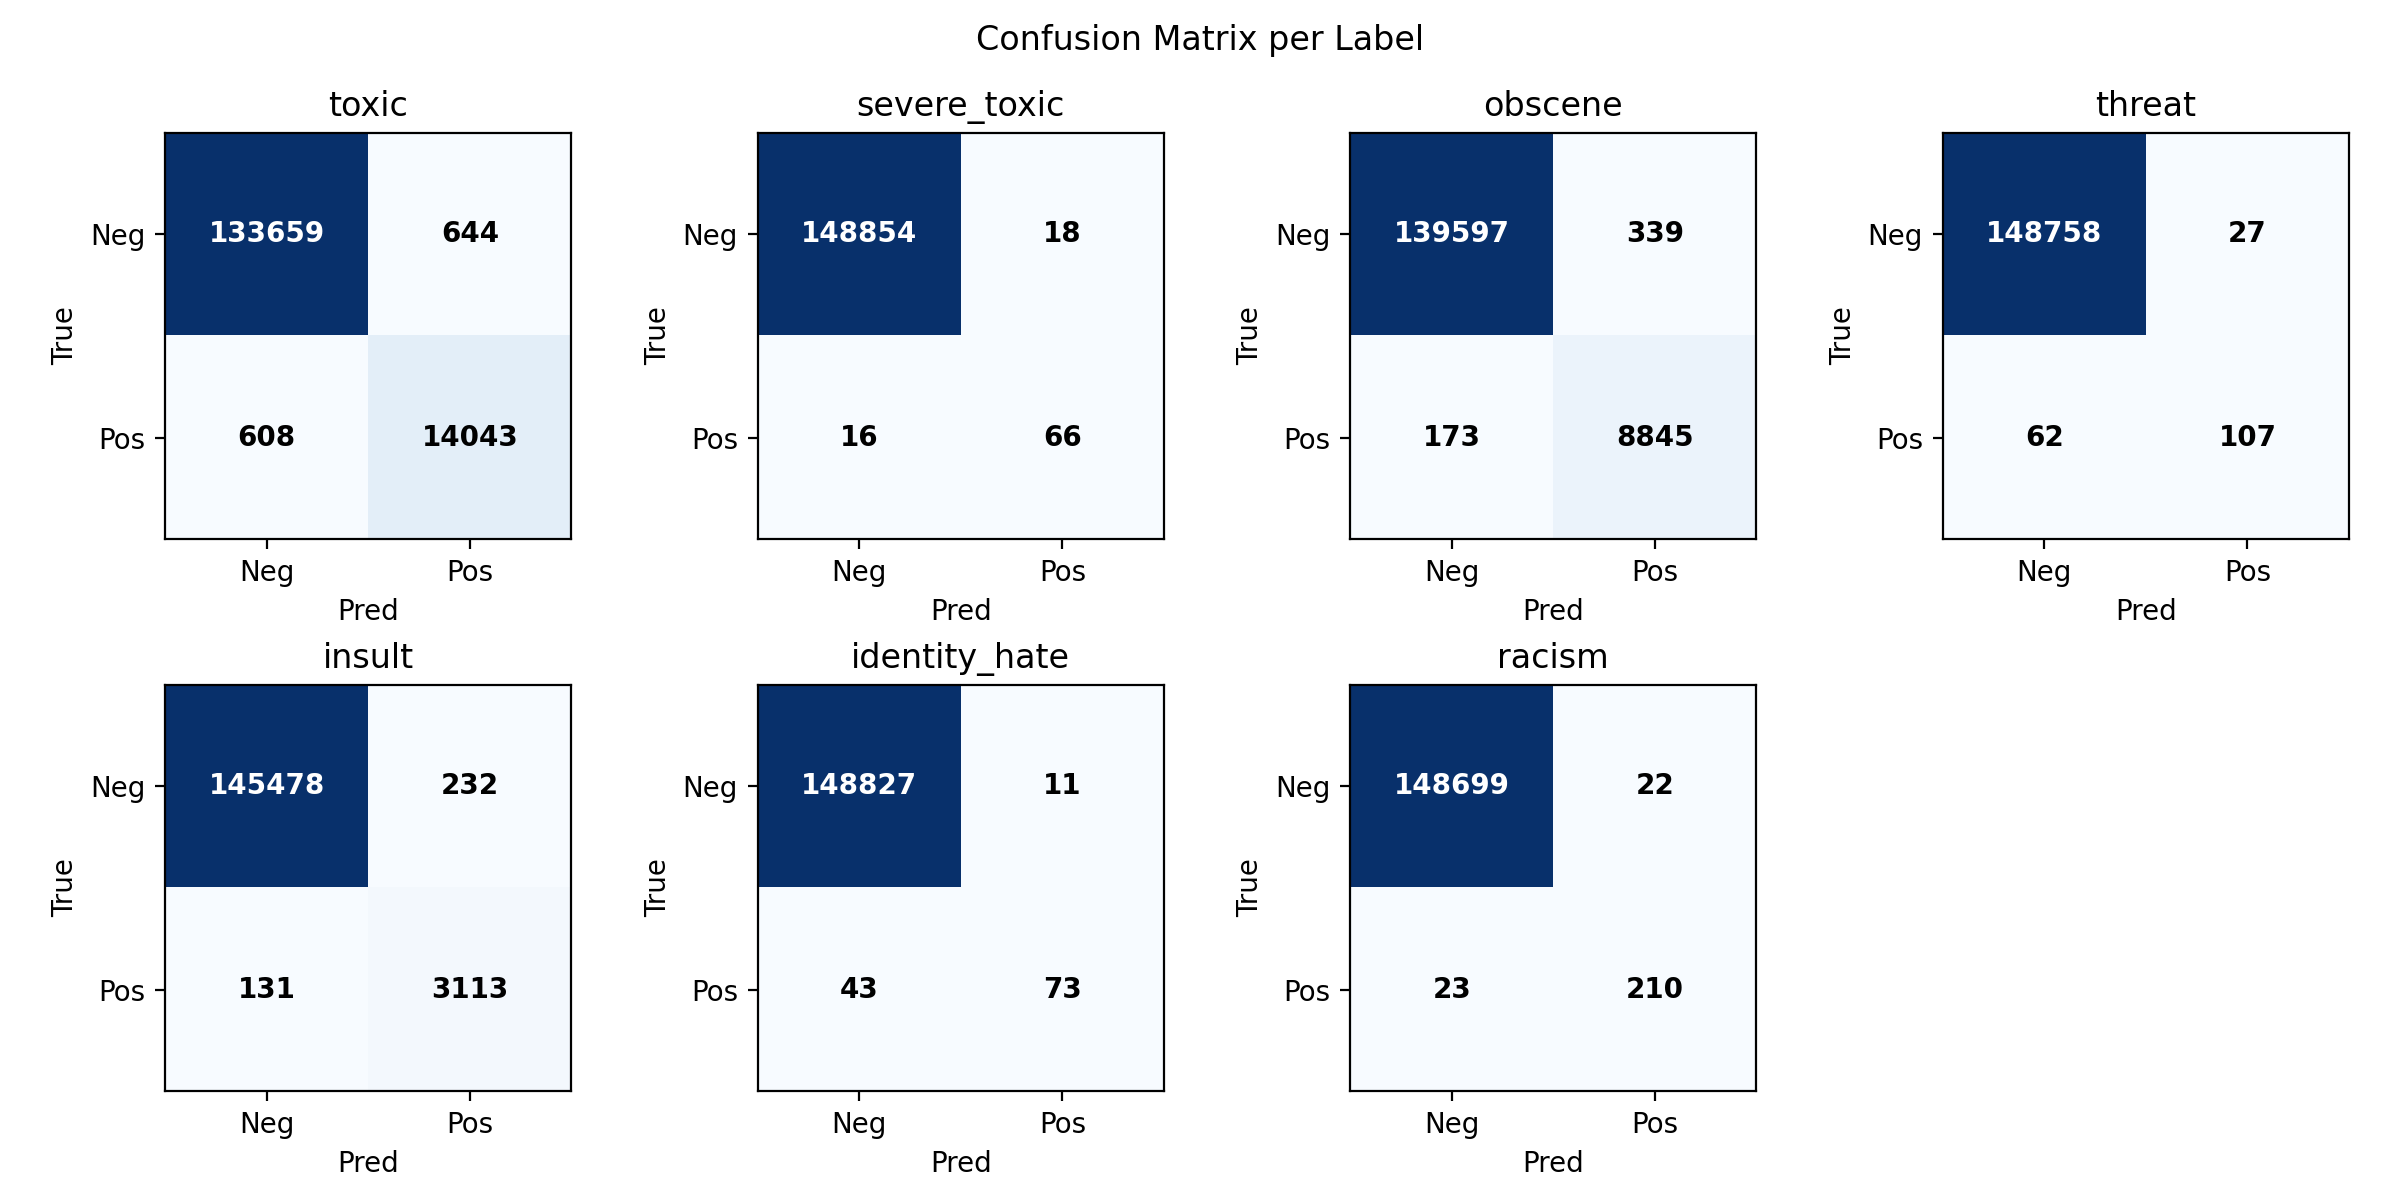

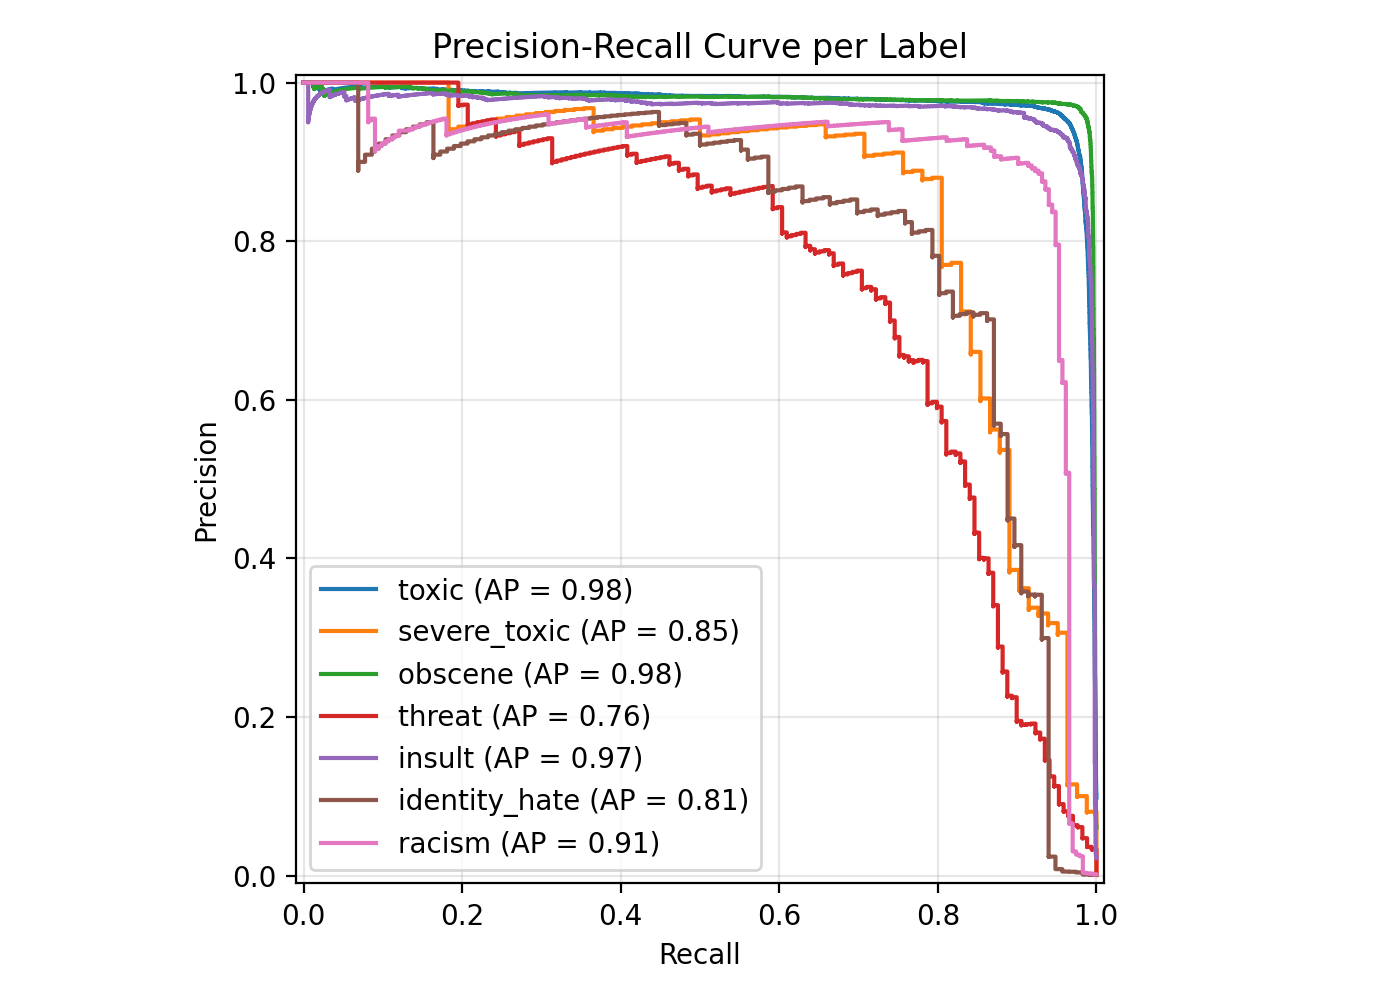

In [22]:
# Derived evaluation visualisations

y_pred = apply_thresholds(test_prob, thresholds, LABELS)

ml_cm = multilabel_confusion_matrix(Y_test, y_pred)



fig_cm, axes = plt.subplots(2, 4, figsize=(12, 6))

axes = axes.flatten()

for idx, lab in enumerate(LABELS):

    cm = ml_cm[idx]

    ax = axes[idx]

    im = ax.imshow(cm, cmap="Blues")

    max_val = cm.max() if cm.size else 0

    for (i, j), value in np.ndenumerate(cm):

        text_color = "white" if max_val and value >= 0.6 * max_val else "black"

        ax.text(j, i, int(value), ha="center", va="center", color=text_color, weight="bold")

    ax.set_title(lab)

    ax.set_xticks([0, 1])

    ax.set_xticklabels(["Neg", "Pos"])

    ax.set_yticks([0, 1])

    ax.set_yticklabels(["Neg", "Pos"])

    ax.set_ylabel("True")

    ax.set_xlabel("Pred")

axes[-1].axis("off")

fig_cm.suptitle("Confusion Matrix per Label")

fig_cm.tight_layout()

cm_path = REPORTS / "confusion_matrix_multilabel.png"

fig_cm.savefig(cm_path, dpi=200)

plt.close(fig_cm)

display(Image(filename=str(cm_path)))



fig_pr, ax_pr = plt.subplots(figsize=(7, 5))

for i, lab in enumerate(LABELS):

    PrecisionRecallDisplay.from_predictions(

        Y_test[:, i],

        test_prob[:, i],

        name=lab,

        ax=ax_pr,

    )

ax_pr.set_title("Precision-Recall Curve per Label")

ax_pr.set_xlabel("Recall")

ax_pr.set_ylabel("Precision")

ax_pr.grid(alpha=0.3)

fig_pr.tight_layout()

pr_path = REPORTS / "precision_recall_curves.png"

fig_pr.savefig(pr_path, dpi=200)

plt.close(fig_pr)

display(Image(filename=str(pr_path)))

In [18]:
def evaluate_all(y_true, y_prob, label_names, thresholds=None, title=""):

    if thresholds is None:

        thresholds = {lab: 0.5 for lab in label_names}

    y_pred = apply_thresholds(y_prob, thresholds, label_names)



    lines, ap_per, roc_per = [], [], []

    for i, lab in enumerate(label_names):

        y_true_col = y_true[:, i]

        y_prob_col = y_prob[:, i]

        ap = average_precision_score(y_true_col, y_prob_col) if y_true_col.sum() > 0 else float("nan")

        roc = roc_auc_score(y_true_col, y_prob_col) if len(np.unique(y_true_col)) > 1 else float("nan")

        p = precision_score(y_true_col, y_pred[:, i], zero_division=0)

        r = recall_score(y_true_col, y_pred[:, i], zero_division=0)

        f = f1_score(y_true_col, y_pred[:, i], zero_division=0)

        ap_per.append(ap)

        roc_per.append(roc)

        lines.append(f"{lab:15s}  AP={ap:.3f}  ROC-AUC={roc:.3f}  P={p:.3f} R={r:.3f} F1={f:.3f} thr={thresholds[lab]:.2f}")



    micro_f1 = f1_score(y_true, y_pred, average="micro", zero_division=0)

    macro_f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)

    subset_acc = accuracy_score(y_true, y_pred)

    subset_err = 1.0 - subset_acc

    summary = (

        f"\n{title}\n"

        f"Micro-F1={micro_f1:.3f}  Macro-F1={macro_f1:.3f}  "

        f"Subset-Acc={subset_acc:.3f}  Subset-Err={subset_err:.3f}\n"

        + "\n".join(lines)

    )

    print(summary)

    return summary



read_kwargs = dict(dtype=str, keep_default_na=False)



train_df = pd.read_csv(DATA_PROCESSED / "train.csv", **read_kwargs)

val_df = pd.read_csv(DATA_PROCESSED / "val.csv", **read_kwargs)

test_df = pd.read_csv(DATA_PROCESSED / "test.csv", **read_kwargs)



for split_name, frame in [("train", train_df), ("val", val_df), ("test", test_df)]:

    missing = frame["body_clean"].eq("").sum() + frame["body_clean"].isna().sum()

    if missing:

        print(f"[{split_name}] dropping {missing} rows with empty body_clean")

        frame.drop(frame[frame["body_clean"].isna() | frame["body_clean"].eq("")].index, inplace=True)

    frame["body_clean"] = frame["body_clean"].astype(str)



Y_train = train_df[LABELS].values.astype(int)

Y_val = val_df[LABELS].values.astype(int)

Y_test = test_df[LABELS].values.astype(int)



vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_df=0.9, sublinear_tf=True)

X_train = vectorizer.fit_transform(train_df["body_clean"])

X_val = vectorizer.transform(val_df["body_clean"])

X_test = vectorizer.transform(test_df["body_clean"])



clf = OneVsRestClassifier(LogisticRegression(max_iter=4000, class_weight="balanced"))

clf.fit(X_train, Y_train)



val_prob = clf.predict_proba(X_val)

thresholds = calibrate_thresholds(Y_val, val_prob, LABELS)

test_prob = clf.predict_proba(X_test)



report = evaluate_all(Y_test, test_prob, LABELS, thresholds, title="[Baseline] Test metrics (calibrated)")

Path("outputs/reports").mkdir(parents=True, exist_ok=True)

Path("outputs/reports/baseline_report.txt").write_text(report, encoding="utf-8")



# Save artifacts

model_dir = Path("outputs/models/baseline")

model_dir.mkdir(parents=True, exist_ok=True)

joblib.dump(vectorizer, model_dir / "vectorizer.joblib")

joblib.dump(clf, model_dir / "ovr_lr.joblib")

(model_dir / "labels.txt").write_text("\n".join(LABELS), encoding="utf-8")

(model_dir / "thresholds.json").write_text(json.dumps(thresholds, indent=2), encoding="utf-8")

print("Baseline artifacts saved to", model_dir)



[Baseline] Test metrics (calibrated)
Micro-F1=0.957  Macro-F1=0.858  Subset-Acc=0.990  Subset-Err=0.010
toxic            AP=0.976  ROC-AUC=0.997  P=0.956 R=0.959 F1=0.957 thr=0.65
severe_toxic     AP=0.852  ROC-AUC=1.000  P=0.786 R=0.805 F1=0.795 thr=0.50
obscene          AP=0.980  ROC-AUC=0.998  P=0.963 R=0.981 F1=0.972 thr=0.65
threat           AP=0.762  ROC-AUC=0.999  P=0.799 R=0.633 F1=0.706 thr=0.95
insult           AP=0.968  ROC-AUC=0.998  P=0.931 R=0.960 F1=0.945 thr=0.75
identity_hate    AP=0.814  ROC-AUC=0.980  P=0.869 R=0.629 F1=0.730 thr=0.65
racism           AP=0.906  ROC-AUC=0.988  P=0.905 R=0.901 F1=0.903 thr=0.45
Baseline artifacts saved to outputs\models\baseline
Baseline artifacts saved to outputs\models\baseline


In [19]:
class BCELossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        loss = custom_loss(outputs, labels)
        return (loss, outputs) if return_outputs else loss

In [20]:

from typing import Tuple

def load_baseline(model_dir=Path("outputs/models/baseline")) -> Tuple:
    vec = joblib.load(model_dir / "vectorizer.joblib")
    clf = joblib.load(model_dir / "ovr_lr.joblib")
    labels = (model_dir / "labels.txt").read_text(encoding="utf-8").splitlines()
    thresholds = json.loads((model_dir / "thresholds.json").read_text(encoding="utf-8"))
    return vec, clf, labels, thresholds

def infer_baseline(texts: List[str], model_dir=Path("outputs/models/baseline")):
    vec, clf, labels, thresholds = load_baseline(model_dir)
    X = vec.transform([normalize_text(t) for t in texts])
    prob = clf.predict_proba(X)
    preds = apply_thresholds(prob, thresholds, labels)
    return labels, prob, preds

def load_transformer(model_dir=Path("outputs/models/transformer/final")):
    tok = AutoTokenizer.from_pretrained(str(model_dir))
    mdl = AutoModelForSequenceClassification.from_pretrained(str(model_dir))
    labels = (model_dir / "labels.txt").read_text(encoding="utf-8").splitlines()
    thresholds = json.loads((model_dir / "thresholds.json").read_text(encoding="utf-8"))
    return tok, mdl, labels, thresholds

def infer_transformer(texts: List[str], model_dir=Path("outputs/models/transformer/final"), max_len=256):
    tok, mdl, labels, thresholds = load_transformer(model_dir)
    enc = tok(texts, truncation=True, padding=True, max_length=max_len, return_tensors="pt")
    mdl.eval()
    with torch.no_grad():
        logits = mdl(**{k: v for k,v in enc.items()})[0]
        probs = torch.sigmoid(logits).cpu().numpy()
    preds = apply_thresholds(probs, thresholds, labels)
    return labels, probs, preds


In [21]:
sample_texts = [
    "I'm so happy with this patch and the dev team did an amazing job!",
    "You're such an idiot, go crawl back to your cave.",
    "I'm a hater.",
    "Bro I hate this game.",
    "Bruh."
]

labels, probs, preds = infer_baseline(sample_texts)

for text, prob_row, pred_row in zip(sample_texts, probs, preds):
    active = [lab for lab, is_on in zip(labels, pred_row) if is_on]
    print("TEXT:", text)
    print("Active labels:", active or ["none"])
    print("Probabilities:", {lab: round(float(p), 3) for lab, p in zip(labels, prob_row)})
    print("-" * 60)

TEXT: I'm so happy with this patch and the dev team did an amazing job!
Active labels: ['none']
Probabilities: {'toxic': 0.029, 'severe_toxic': 0.001, 'obscene': 0.022, 'threat': 0.001, 'insult': 0.013, 'identity_hate': 0.004, 'racism': 0.003}
------------------------------------------------------------
TEXT: You're such an idiot, go crawl back to your cave.
Active labels: ['toxic', 'insult']
Probabilities: {'toxic': 0.998, 'severe_toxic': 0.005, 'obscene': 0.028, 'threat': 0.008, 'insult': 1.0, 'identity_hate': 0.06, 'racism': 0.004}
------------------------------------------------------------
TEXT: I'm a hater.
Active labels: ['none']
Probabilities: {'toxic': 0.005, 'severe_toxic': 0.001, 'obscene': 0.003, 'threat': 0.0, 'insult': 0.001, 'identity_hate': 0.007, 'racism': 0.002}
------------------------------------------------------------
TEXT: Bro I hate this game.
Active labels: ['toxic']
Probabilities: {'toxic': 1.0, 'severe_toxic': 0.0, 'obscene': 0.029, 'threat': 0.002, 'insult':